# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 12 Apr 2024** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df_train = pd.read_csv('data_topic/train.csv',names=['label','text'])
df_test = pd.read_csv('data_topic/test.csv', names = ['label','text'])
df_dev = pd.read_csv('data_topic/dev.csv', names = ['label','text'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    

    ## Extract tokens from the document
    tokens = re.findall(token_pattern, x_raw.lower())


    ## Remove stop words from the tokens
    tokens = [t for t in tokens if t not in stop_words]
    
    x = []

    ## Extract n-grams
    for n in range(ngram_range[0], ngram_range[1]+1):
        for i in range(len(tokens)-n+1):
            ngram = ' '.join(tokens[i:i+n])
            if vocab:
                if ngram in vocab:
                    x.append(ngram)
            else:
                x.append(ngram)
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [5]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    ### Initialize the vocabulary and document frequency dictionary
    vocab = set()
    df = {}
    ngram_counts = {}
    
    ## Extract n-grams from each document
    ngrams = [extract_ngrams(x, ngram_range, stop_words=stop_words, token_pattern=token_pattern) for x in X_raw.iloc[:,1]]

    ## Iterate through each document's n-grams and populate the vocabulary and document frequency
    for i, sublist in enumerate(ngrams):
        for word in sublist:
            vocab.add(word)
            ngram_counts[word] = ngram_counts.get(word, 0) + 1

            if word in df.keys():
                df[word] += 1
            else:
                df[word] = 1

    # filtering out ngrams that have document frequency less than min_df
    words_to_discard = set()

    for word in vocab:
        if ngram_counts[word] < min_df:
            words_to_discard.add(word)

    vocab = vocab - words_to_discard

    # Filter n-grams based on keep_topN
    
    if keep_topN >0:
        sorted_df = sorted(df.items(), key=lambda x: x[1], reverse=True)
        words_to_retain = set([x[0] for x in sorted_df[:keep_topN]])
        vocab = vocab & words_to_retain
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [6]:
df_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

vocab,df_extract,ngram_counts = get_vocab(df_train, ngram_range=(1,1), stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [7]:
#vocab id -> word dictionary

id2word = {i:w for i,w in enumerate(vocab)}

#word -> vocab id dictionary

word2id = {w:i for i,w in id2word.items()}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [8]:
# train, dev and test sets as lists of words in the vocabulary

X_tr = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in df_train.iloc[:,1]]
X_dev = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in df_dev.iloc[:,1]]
X_te = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words, vocab=vocab) for x in df_test.iloc[:,1]]

Then convert them into lists of indices in the vocabulary:

In [9]:
# convert them into lists of indices in the vocabulary

X_tr = [[word2id[w] for w in x] for x in X_tr]
X_dev = [[word2id[w] for w in x] for x in X_dev]
X_te = [[word2id[w] for w in x] for x in X_te]

Put the labels `Y` for train, dev and test sets into arrays: 

In [10]:
#Put the labels `Y` for train, dev and test sets into arrays: 

Y_tr = df_train.iloc[:,0].values
Y_dev = df_dev.iloc[:,0].values
Y_te = df_test.iloc[:,0].values

Y_te = [i -1 for i in Y_te]

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [11]:
### Initialize random weights to create the weight matrix/network

def network_weights(vocab_size=1000,embedding_dim=300,hidden_dim=[],num_classes=3,init_val=0.5):

    W = {}
    W[0] = np.random.uniform(-init_val,init_val,(vocab_size,embedding_dim)).astype(np.float32)
    prev_dim = embedding_dim
    for i,h in enumerate(hidden_dim):
        W[i+1] = np.random.uniform(-init_val,init_val,(prev_dim,h)).astype(np.float32)
        prev_dim = h

    output_dim = hidden_dim[-1] if hidden_dim else embedding_dim
    W[len(hidden_dim) + 1] = np.random.uniform(-init_val, init_val, (output_dim, num_classes)).astype(np.float32)
    return W

In [12]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [13]:
### Defining the softmax function

def softmax(z):
    z = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(z)
    sig = exp_z / np.sum(exp_z, axis=0)
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [14]:
## Cross-entropy loss function

def categorical_loss(y, y_preds):
    
    l = -np.sum(y*np.log(y_preds+1e-9))+1e-8

    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [15]:
## Defining relu and relu derivative functions

def relu(z):
    a = np.maximum(0,z)
    
    return a
    
def relu_derivative(z):
    dz = np.where(z>0, 1, 0)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [16]:
## Dropout Regularization function

def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.random.binomial(1, 1-dropout_rate, size)
    return dropout_vec
    

In [17]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 0 1 1 1 1 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [18]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    # Embedding layer
    h = np.mean(W[0][x], axis=0)
    
    h_vecs.append(h)
    dropout_mask_ = dropout_mask(h.shape, dropout_rate)
    dropout_vecs.append(dropout_mask_)
    h *= dropout_mask_

    a_vecs.append(h)

    # Hidden layers
    if len(W) > 2:
        for i in range(1,len(W)-1):
            h = np.dot(h, W[i])
            h_vecs.append(h)
            
            a = relu(h)
            
            dropout_mask_ = dropout_mask(a.shape, dropout_rate)
            dropout_vecs.append(dropout_mask_)
            
            h *= dropout_mask_
            a_vecs.append(h)


    # Output layer
    h = np.dot(h, W[len(W) - 1])
    y_preds = softmax(h)
    out_vals['y_preds'] = y_preds
    


    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    
    return out_vals


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [19]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):

    y_preds = out_vals['y_preds']
    h_vecs = out_vals['h']
    a_vecs = out_vals['a']
    dropout_vecs = out_vals['dropout']

    #output layer
    delta = y_preds - y
    dW_out = np.outer(a_vecs[-1], delta)
    W[len(W)-1] -= lr*dW_out

    #hidden layers
    for i in range(len(W)-2, 0, -1):
        delta = np.dot(delta, W[i+1].T)
        delta = delta * relu_derivative(h_vecs[i])
        delta = delta * dropout_vecs[i]
        dW = np.outer(a_vecs[i - 1],delta)
        W[i] -= lr*dW

    #embedding layer
    if not freeze_emb:
        delta = np.dot(delta, W[1].T)
        delta = delta * dropout_vecs[0]
        for i in range(len(x)):
            W[0][x[i]] -= lr*delta
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [20]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.01, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = [] 
    validation_loss_history = []

    for epoch in range(epochs):
        
        ## SGD for training dataset
        
        training_loss = 0
        for x,y in zip(X_tr, Y_tr):
            ## One-hot encode the target label
            y_onehot = np.zeros(3)
            y_onehot[y-1] = 1

            ### Forward pass and calculate the loss - Update the weights with backward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)
            W = backward_pass(x, y_onehot, W, out_vals, lr=lr, freeze_emb=freeze_emb)
            training_loss += categorical_loss(y_onehot, out_vals['y_preds'])
        
        training_loss /= len(Y_tr)
        training_loss_history.append(training_loss)
        
        ## SGD for validation dataset


        if X_dev:
            validation_loss = 0
            for x,y in zip(X_dev, Y_dev):

                ## One-hot encode the target label
                y_onehot = np.zeros(3)
                y_onehot[y-1] = 1

                ### Forward pass and calculate the loss
                out_vals = forward_pass(x, W, dropout_rate=dropout)
                validation_loss += categorical_loss(y_onehot, out_vals['y_preds'])
            validation_loss /= len(Y_dev)
            validation_loss_history.append(validation_loss)
        
        if print_progress:
            print('Epoch %d, training loss: %.4f, validation loss: %.4f' % (epoch, training_loss, validation_loss))
        
        if epoch > 1 and abs(validation_loss - validation_loss_history[-2]) < tolerance:
            break
    
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [21]:
### Param Grid

param_grid = {'lr': [0.001, 0.01, 0.1],
                'dropout': [0.2, 0.3, 0.4],
                'epochs': [20, 50, 100],
                'embedding_dim': [50, 100, 200]}

results = {'embedding_dim': [], 'lr': [], 'dropout': [], 'epochs': [], 'accuracy': []}

In [22]:
### Hyperparameter Tuning - Embedding Dimension

for emb_dim in param_grid['embedding_dim']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=emb_dim, hidden_dim=[], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=0.01, dropout=0.2, epochs=100, tolerance=1e-4, freeze_emb=False, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Embedding dim: %d, Accuracy: %.4f' % (emb_dim, acc))
    results['embedding_dim'].append(acc)

Embedding dim: 50, Accuracy: 0.8556
Embedding dim: 100, Accuracy: 0.8522
Embedding dim: 200, Accuracy: 0.8522


In [23]:
### Hyperparameter Tuning - Learning Rate

for lr in param_grid['lr']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=param_grid['embedding_dim'][np.argmax(results['embedding_dim'])], hidden_dim=[], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, epochs=100, tolerance=1e-4, freeze_emb=False, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Learning rate: %.4f, Accuracy: %.4f' % (lr, acc))
    results['lr'].append(acc)

Learning rate: 0.0010, Accuracy: 0.8544
Learning rate: 0.0100, Accuracy: 0.8511
Learning rate: 0.1000, Accuracy: 0.8189


In [24]:
### Hyperparameter Tuning - Dropout Rate

for dropout in param_grid['dropout']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=param_grid['embedding_dim'][np.argmax(results['embedding_dim'])], hidden_dim=[], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=dropout, epochs=100, tolerance=1e-4, freeze_emb=False, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Dropout rate: %.4f, Accuracy: %.4f' % (dropout, acc))
    results['dropout'].append(acc)

Dropout rate: 0.2000, Accuracy: 0.8522
Dropout rate: 0.3000, Accuracy: 0.8544
Dropout rate: 0.4000, Accuracy: 0.8567


In [25]:
### Hyperparameter Tuning - epochs

for epoch in param_grid['epochs']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=param_grid['embedding_dim'][np.argmax(results['embedding_dim'])], hidden_dim=[], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=param_grid['dropout'][np.argmax(results['dropout'])], epochs=epoch, tolerance=1e-4, freeze_emb=False, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Epochs: %d, Accuracy: %.4f' % (epoch, acc))
    results['epochs'].append(acc)

Epochs: 20, Accuracy: 0.7833
Epochs: 50, Accuracy: 0.8322
Epochs: 100, Accuracy: 0.8611


In [26]:
### Best fit

best_params = {}
best_params['embedding_dim'] = param_grid['embedding_dim'][np.argmax(results['embedding_dim'])]
best_params['lr'] = param_grid['lr'][np.argmax(results['lr'])]
best_params['dropout'] = param_grid['dropout'][np.argmax(results['dropout'])]
best_params['epochs'] = param_grid['epochs'][np.argmax(results['epochs'])]


W = network_weights(vocab_size=len(vocab),embedding_dim=best_params['embedding_dim'],hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,
                            lr=best_params['lr'], 
                            dropout=best_params['dropout'],
                            freeze_emb=False,
                            tolerance=1e-7,
                            epochs=best_params['epochs'],
                            print_progress=False)


Shape W0 (8931, 50)
Shape W1 (50, 3)


Plot the learning process:

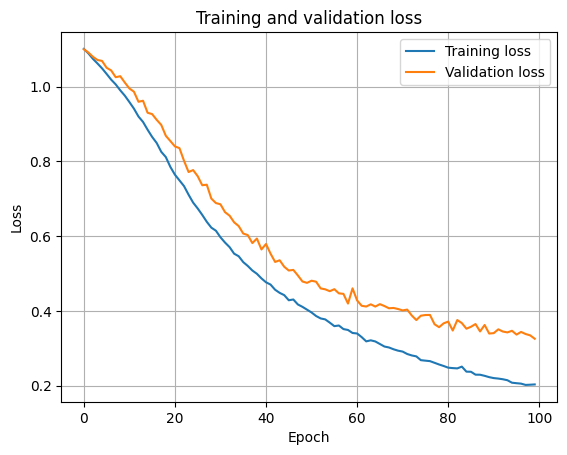

In [27]:
#plotting the training and validation loss

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid()

Compute accuracy, precision, recall and F1-Score:

In [28]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) 
            for x,y in zip(X_te,Y_te)]


print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8522222222222222
Precision: 0.8539734893860919
Recall: 0.8522222222222222
F1-Score: 0.8520529115797327


### Discuss how did you choose model hyperparameters ? 

Careful consideration is required for identifying the hyperparameters associated with the Stochastic Gradient Descent Algorithm to achieve optimal model performance. The choice of hyperparameters that include the number of epochs, learning rate, dropout rate and dimension of the embedding layer contribute to efficiently achieving the model's convergence and generalization capabilities.

The combination of epochs and learning rate contribute to the rate of iterations and the convergence. Lower values of epochs along with lower learning rates could lead to non-convergence and on the other end, higher epochs results in overfitting. A larger learning rate may also affect the lowest value for the loss function. 

The embedding layer and the dropout focus on how well the model computes the function based on the training data. Embedding layer indicates the number of neurons whose weights are tuned to effectively reduce the categorical cross entropy loss. The dropout rate focuses on removing a set of neurons to prevent from the weight to overfit over the provided dataset, effectively increasing the generalization capabilities.

It can be noted that a wide vareity of ranges for each hyperparameter is chosen to ensure optimal values are attained. Another noteworthy observation is the decoupled tuning of hyperparameters and chaining the optimal value to the next optimization step. This approach is undertaken for better understanding of the impact which is created by each hyperparameter individually, apart from the lesser computation time undertaken. This process present a strategic exploration process to better understand the parameter space. It is also criticial to understand that the tuning is performed on the accuracy of unseen data focusing on improving the generalization capabilities.

It can be noted that all the presented accuracy metrics that include accuracy, precision, recall and F1-score are in the range of 85% showing a fairly accurate metric for the given model. The graph plotted for the training and validation loss presents an exponential drop across the number of iterations (epochs).This phenomenon indicates that the model converges to the optimal solution with fine-tuned network weights. The effect of dropout regularization can be inferred from the figure that the model is not overfit.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [29]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:])
                    try:
                        emb =  emb.astype(np.float32)
                    except:
                        print("Original line:", line)
                        print("Word:", word)
                        print("Strip and split : ",line.strip('\n').split())
                        break
                    w_emb[word2id[word]] +=emb
    return w_emb

In [30]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [31]:
### Param Grid

param_grid = {'lr': [0.001, 0.01, 0.1],
                'dropout': [0.2, 0.3, 0.4],
                'epochs': [20, 50, 100]}

results = {'lr': [], 'dropout': [], 'epochs': []}

In [32]:
### Hyperparameter Tuning - Learning Rate

for lr in param_grid['lr']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3)
    W[0] = w_glove
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, epochs=100, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Learning rate: %.4f, Accuracy: %.4f' % (lr, acc))
    results['lr'].append(acc)

Learning rate: 0.0010, Accuracy: 0.8933
Learning rate: 0.0100, Accuracy: 0.8078
Learning rate: 0.1000, Accuracy: 0.6656


In [33]:
### Hyperparameter Tuning - Dropout Rate

for dropout in param_grid['dropout']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3)
    W[0] = w_glove
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=dropout, epochs=100, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Dropout rate: %.4f, Accuracy: %.4f' % (dropout, acc))
    results['dropout'].append(acc)

Dropout rate: 0.2000, Accuracy: 0.8889
Dropout rate: 0.3000, Accuracy: 0.8933
Dropout rate: 0.4000, Accuracy: 0.8911


In [34]:
### Hyperparameter Tuning - epochs

for epoch in param_grid['epochs']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3)
    W[0] = w_glove
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=param_grid['dropout'][np.argmax(results['dropout'])], epochs=epoch, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Epochs: %d, Accuracy: %.4f' % (epoch, acc))
    results['epochs'].append(acc)

Epochs: 20, Accuracy: 0.8556
Epochs: 50, Accuracy: 0.8911
Epochs: 100, Accuracy: 0.8978


In [35]:
### Best fit

best_params = {}
best_params['lr'] = param_grid['lr'][np.argmax(results['lr'])]
best_params['dropout'] = param_grid['dropout'][np.argmax(results['dropout'])]
best_params['epochs'] = param_grid['epochs'][np.argmax(results['epochs'])]

W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)


W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=best_params['lr'], 
                            dropout=best_params['dropout'],
                            freeze_emb=True,
                            tolerance=1e-7,
                            epochs=best_params['epochs'],
                            print_progress=False)


Shape W0 (8931, 300)
Shape W1 (300, 3)


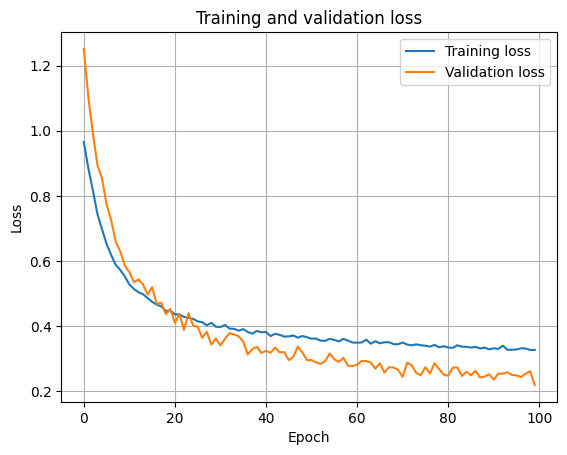

In [36]:
#plotting the training and validation loss

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid()

In [37]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8911111111111111
Precision: 0.8908410763652252
Recall: 0.8911111111111111
F1-Score: 0.8901658045436157


### Discuss how did you choose model hyperparameters ? 

In this case, the embedding layer is replaced by a pre-tuned layers from GLoVe embeddings. It is also followed by freezing the embedding layer throughout the Stocastic Gradient Descent process. Similar hyperparameters are chosen in this scenario including learning rate, number of epochs and dropout rate. As the embedding layer is fixed with 300 from the GLoVe embeddings, it is not tuned.

The learning rate and epochs come together to control the rate for convergence of the optimal solution and along with dropout regulaization with preventing the model from overfitting, the model approachs the most efficient set of hyperparameters.

The performance metrics indicate higher values compared to the previous case. It can be inferred that the tuned emdedding layer plays a vital role in the model's performance and it's generalization capabilities. The presented graph for the validation and training loss showcases a similar exponential decay as the first case. It can also be noted that there are spikes observed across loss rates through epochs. This indicates stochasticity throughout the SGD algorithm from the model initializations. Another factor could the dropout regualarization protecting the model from overfitting.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [38]:
### Param Grid

param_grid = {'lr': [0.001, 0.01, 0.1],
                'dropout': [0.2, 0.3, 0.4],
                'epochs': [20, 50, 100],
                'hidden_dim': [[100],[200],[300]]}

results = {'lr': [], 'dropout': [], 'epochs': [], 'hidden_dim': []}

In [39]:
### Hyperparameter Tuning - Hidden Dimension

for hidden_dim in param_grid['hidden_dim']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=hidden_dim, num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=0.01, dropout=0.2, epochs=100, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Hidden dim:', hidden_dim, 'Accuracy: %.4f' % acc)
    results['hidden_dim'].append(acc)

Hidden dim: [100] Accuracy: 0.6989
Hidden dim: [200] Accuracy: 0.7144
Hidden dim: [300] Accuracy: 0.7022


In [40]:
### Hyperparameter Tuning - Learning Rate

for lr in param_grid['lr']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=param_grid['hidden_dim'][np.argmax(results['hidden_dim'])], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=lr, dropout=0.2, epochs=100, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Learning rate: %.4f, Accuracy: %.4f' % (lr, acc))
    results['lr'].append(acc)

Learning rate: 0.0010, Accuracy: 0.7133
Learning rate: 0.0100, Accuracy: 0.7100
Learning rate: 0.1000, Accuracy: 0.4356


In [41]:
### Hyperparameter Tuning - Dropout Rate

for dropout in param_grid['dropout']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=param_grid['hidden_dim'][np.argmax(results['hidden_dim'])], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=dropout, epochs=100, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Dropout rate: %.4f, Accuracy: %.4f' % (dropout, acc))
    results['dropout'].append(acc)

Dropout rate: 0.2000, Accuracy: 0.7056
Dropout rate: 0.3000, Accuracy: 0.7144
Dropout rate: 0.4000, Accuracy: 0.7133


In [42]:
### Hyperparameter Tuning - epochs

for epoch in param_grid['epochs']:
    W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=param_grid['hidden_dim'][np.argmax(results['hidden_dim'])], num_classes=3)
    W, training_loss, validation_loss = SGD(X_tr, Y_tr, W, X_dev=X_dev, Y_dev=Y_dev, lr=param_grid['lr'][np.argmax(results['lr'])], dropout=param_grid['dropout'][np.argmax(results['dropout'])], epochs=epoch, tolerance=1e-4, freeze_emb=True, print_progress=False)
    preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) for x in X_te]
    acc = accuracy_score(Y_te, preds_te)
    print('Epochs: %d, Accuracy: %.4f' % (epoch, acc))
    results['epochs'].append(acc)

Epochs: 20, Accuracy: 0.6689
Epochs: 50, Accuracy: 0.6989
Epochs: 100, Accuracy: 0.7300


In [43]:
best_params = {}
best_params['hidden_dim'] = param_grid['hidden_dim'][np.argmax(results['hidden_dim'])]
best_params['lr'] = param_grid['lr'][np.argmax(results['lr'])]
best_params['dropout'] = param_grid['dropout'][np.argmax(results['dropout'])]
best_params['epochs'] = param_grid['epochs'][np.argmax(results['epochs'])]


W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=best_params['hidden_dim'], num_classes=3)


W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=best_params['lr'], 
                            dropout=best_params['dropout'],
                            freeze_emb=True,
                            tolerance=1e-7,
                            epochs=best_params['epochs'],
                            print_progress=False)


Shape W0 (8931, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)


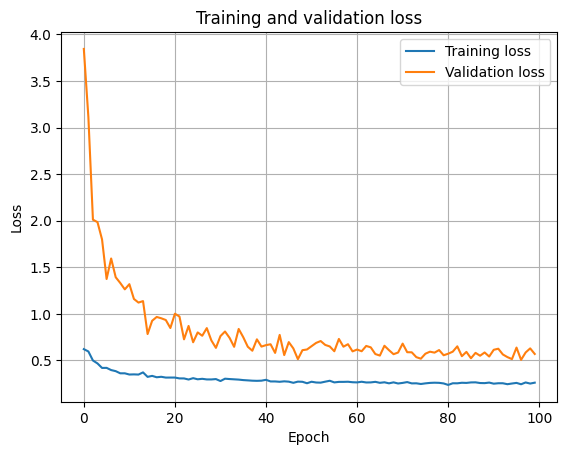

In [44]:
#plotting the training and validation loss

plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid()

In [45]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8077777777777778
Precision: 0.8485872968111119
Recall: 0.8077777777777778
F1-Score: 0.7977047505269387


### Discuss how did you choose model hyperparameters ? 

In the final scenario, we have introduced an additional hidden layer along with the pre-trained Glove embedding layer. The number of neurons in the hidden layer is also added to the stack of hyperparameters that consists of learning rate, number of epochs and dropout rate. The addition of hidden layer brings more complexity to the model. A single hidden layer is considered with a wide range of neurons to account for a large parameter space.

The existing tuning is done similar to the previous cases of chaining individual hyperparameter optimization based on accuracy of test data. This aids in attaining high capabilities of the model of generalization.

A contrasting set of values of the performance metrics are observed. It is seen that the metrics are lower than the previous case of having no hidden layers but higher than the first case of not considering the pre-trained embeddings. This could be due to a number of factors. One of them is that the model is overfitting with the addition of a hidden layer. This could be due to the ability of the model to capture unnecessary patterns from the hidden layer leading to lower performance on the test data. Another factor could be due to the dropout regularization. Insufficient dropping of neurons could result in certain neurons across the emebedding and the hidden layer. The last factor could be that the gradient descent algorithm identifies local minima of the loss function due to the presence of hidden layers.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 84.9% | 84.8% | 84.8% | 84.8% |
| Average Embedding (Pre-trained)  | 89.3% | 89.3% | 89.2% | 89.3% |
| Average Embedding (Pre-trained) + X hidden layers    | 88.2% | 87.8% | 87.6% | 87.8% |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

From the observations of the performance metrics across the 3 cases, it can be seen that the second model that consists of pre-trained embedding layer from GloVe with no hidden layers has the highest values. This is due to the ability of not overfitting compared to the third model with hidden layers. It performs better than the first model due to the embedding layer which is pre-trained decreasing the model's capability to generalize over unseen data.

Across all the models, there is a common exponential decay of training and validation loss across epochs with spikes observed when the pre-embedding layer is accounted. It is also noteworthy to observe that the training loss has been lower than validation loss from which we can conclude that the model is not overfit.